# Keras API

So far, we worked directly on the **computational graphs with the low-level APIs.** TensorFlow relies on those graphs internally and it's a good idea to always think in terms of nodes, operations, graphs, and sessions. However, we don't always need to work with those concepts directly and can leverage higher-level APIs that simplify the design and training process.

In this unit, we present **the Keras API which is now the recommended TensorFlow official high-level interface.**

### Keras model

Keras functionalities can be found under the tf.keras module. In this unit, we will mainly work with the objects from its layers submodule and assemble them in a Sequential model

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]= "-1"
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

C:\Users\lyeso\anaconda3\envs\exts-ml\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=28*28))
model.add(Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                12560     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________


In this code, we first create the Sequential model and add each layer object. In our case, we create Dense layers by specifying the number of units, the activation function and the input dimensions i.e. a flat vector with 28x28=784 values. Finally, we print a summary of our network that displays the different layers and their number of parameters. As we can see, most of them are in the hidden layer with 12,560 parameters i.e. 784x16=12,544 weights and 16 bias values.

> **Note**: When we use TensorFlow's low-level interface, we set the last layer activation to None and then use the softmax_cross_entropy_with_logits loss function which computes the class probability distribution (softmax) and the loss value (cross-entropy) in one operation to avoid potential numerical issues. You can read more about this in this article https://blog.feedly.com/tricks-of-the-trade-logsumexp/. Keras handles this internally, and we don't have to combine them into one operation: we can set the output layer activation to softmax and then use the cross-entropy loss function when defining the optimizer. One important difference is that our network will output the class probability distribution directly instead of the class scores (logits).

By default, **Keras initializes the weights with the variance scaling technique that we have seen in the last subject.** However, we can also manually specify the initializers.

In [3]:
from tensorflow.keras import activations
from tensorflow.keras import initializers


# Create model
model = Sequential()

# Hidden layer
model.add(Dense(
    units=16, activation=activations.relu, input_dim=28*28,
    kernel_initializer=initializers.VarianceScaling(scale=2.0, seed=0)))

# Output layer
model.add(Dense(
    units=10, activation=activations.softmax,
    kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=0)))

# Print network summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                12560     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                170       
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________


This network is equivalent to the one from above but fixes the seed number to get reproducible results.

As you can see, we didn't specify a graph. Keras automatically adds the network nodes, variables, placeholders, and operations to the default graph and connects them together according to our Sequential model definition.

### Loss function and training operation
Let's now see how to define the training elements with the Keras syntax:


In [4]:
from tensorflow.keras import optimizers

# Define loss function, optimizer and metrics to track during training
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['acc'])

Keras models provide a **compile() function** where we can specify the **optimizer, the loss function and the metrics to monitor.**

In the code from above, we used predefined tokens such as sgd or acc which are good defaults values. Again, we can also have more control over the different parameters by manually defining the objects from the Keras modules

In [5]:
from tensorflow.keras import losses
from tensorflow.keras import metrics

# Define loss function, optimizer, and metrics to track during training
model.compile(
    optimizer='sgd', # .. or optimizers.SGD(lr=0.01)
    loss='sparse_categorical_crossentropy', # .. or losses.sparse_categorical_crossentropy
    metrics=['acc'] # .. or metrics.sparse_categorical_accuracy
)

This code is equivalent to the one from above, but we can now specify the learning rate and the other parameters of the optimizer.

### Load/split data

Before training our MNIST classifier, let's load and split the data. Keras already provides many data sets from its datasets module

In [6]:
from tensorflow.keras.datasets.mnist import load_data

(X_train, y_train), (X_test, y_test) = load_data()

print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (60000, 28, 28) (60000,)
Test: (10000, 28, 28) (10000,)


In this code, we use the load_data() function from its mnist module which returns 60k-10k train/test splits with the 28x28 grayscale images and the 0-9 numerical labels.

Our dense network works with flat input vectors. So let's reshape and standardize the data

In [7]:
from sklearn.preprocessing import StandardScaler

# Rescale train and validation data
scaler = StandardScaler()
X_train_preprocessed = scaler.fit_transform(X_train.reshape([-1, 784]).astype(float))
X_test_preprocessed = scaler.transform(X_test.reshape([-1, 784]).astype(float))

print('Train:', X_train_preprocessed.shape) #
print('Test:', X_test_preprocessed.shape) 

Train: (60000, 784)
Test: (10000, 784)


### Training
So far, we manually implemented our own training loops from tf.Session objects. Keras encapsulates this process in its Model fit() function

In [8]:
# Fit model
history = model.fit(
    x=X_train_preprocessed, y=y_train,
    validation_split=0.2, batch_size=32, epochs=50,
    shuffle=True # Shuffle training samples
)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 2s 34us/step - loss: 0.6096 - acc: 0.8220 - val_loss: 0.3292 - val_acc: 0.9065
Epoch 2/50
48000/48000 [==============================] - 1s 19us/step - loss: 0.3096 - acc: 0.9112 - val_loss: 0.2727 - val_acc: 0.9231
Epoch 3/50
48000/48000 [==============================] - 1s 19us/step - loss: 0.2613 - acc: 0.9237 - val_loss: 0.2485 - val_acc: 0.9307
Epoch 4/50
48000/48000 [==============================] - 1s 19us/step - loss: 0.2341 - acc: 0.9321 - val_loss: 0.2315 - val_acc: 0.9358
Epoch 5/50
48000/48000 [==============================] - 1s 19us/step - loss: 0.2160 - acc: 0.9371 - val_loss: 0.2207 - val_acc: 0.9396
Epoch 6/50
48000/48000 [==============================] - 1s 19us/step - loss: 0.2016 - acc: 0.9414 - val_loss: 0.2147 - val_acc: 0.9413
Epoch 7/50
48000/48000 [==============================] - 1s 19us/step - loss: 0.1904 - acc: 0.9450 - val_loss: 0.2069 - val_acc

Keras prints the training/validation loss and accuracy metrics that we specified in the metrics=['acc'] argument from the compile() step.

We can access those values via the history object returned by fit()

In [9]:
# The history object saved the scores during training
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

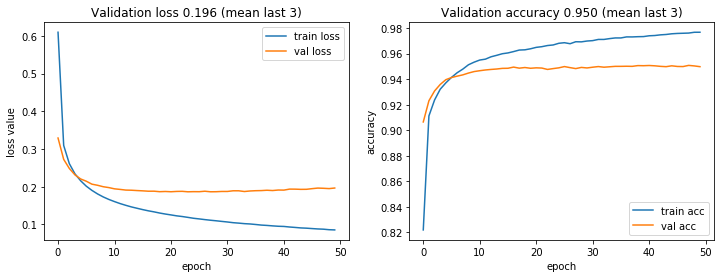

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy values
ax1.plot(history.history['loss'], label='train loss')
ax1.plot(history.history['val_loss'], label='val loss')
ax1.set_title('Validation loss {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_loss'][-3:]) # last three values
))
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss value')
ax1.legend()

# Plot accuracy values
ax2.plot(history.history['acc'], label='train acc')
ax2.plot(history.history['val_acc'], label='val acc')
ax2.set_title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_acc'][-3:]) # last three values
))
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()
plt.show()

We can see that the **validation loss and accuracy reach a plateau after 10 epochs. The model then starts overfitting.**

It's interesting to note that we didn't specify any session. Again, Keras automatically handles this object internally for us.

### Evaluate test scores

In [11]:
(test_loss, test_accuracy) = model.evaluate(X_test_preprocessed, y_test, batch_size=32)

print('Test loss: {:.2f}'.format(test_loss))
print('Test accuracy: {:.2f}%'.format(100*test_accuracy)) 

10000/10000 [==============================] - 0s 10us/step
Test loss: 0.19
Test accuracy: 95.40%


In this code, we use the Model evaluate() function to evaluate the metrics on a new data set. Note that we can specify a batch size such that the evaluation is done by batches of data examples to reduce memory usage.

The function returns the metrics in the same order as the metrics_names model attribute

In [12]:
print(model.metrics_names)

['loss', 'acc']


### Visualize weights
We can extract the layers from our Sequential model with the layers attribute

In [13]:
model.layers

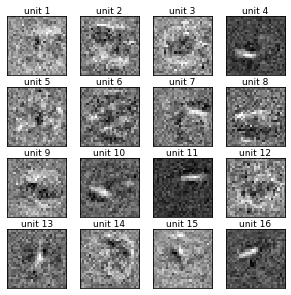

In [14]:
# Retrieve first hidden layer
hidden = model.layers[0]

# Get weights/biases
weights_hidden, biases_hidden = hidden.get_weights()

# Create figure with 16 subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(5, 5))

# Plot the weights of the 16 hidden units
for i, axis in enumerate(axes.flatten()):
    # Get weights of i-th hidden unit
    weights = weights_hidden[:, i]

    # Reshape into 28 by 28 array
    weights = weights.reshape(28, 28)

    # Plot weights
    axis.set_title('unit {}'.format(i+1), size=9, pad=2)
    axis.imshow(weights, cmap=plt.cm.gray_r) # Grayscale
    axis.get_xaxis().set_visible(False) # Disable x-axis
    axis.get_yaxis().set_visible(False) # Disable y-axis

plt.show()

The weights look a bit noisy, adding regularization could potentially help

> **Challenge** - Try with dropout by adding tf.keras.layers.Dropout(x) layers to the Sequential model. Also try with regularization by setting the kernel_regularizer=tf.keras.regularizers.l2(x) parameters from Dense layers

### Dropout Regularization

In [15]:
from tensorflow.keras.layers import Dropout

# Create model
model2 = Sequential()

# Hidden layer
model2.add(Dense(
    units=16, activation=activations.relu, input_dim=28*28,
    kernel_initializer=initializers.VarianceScaling(scale=2.0, seed=0)))

model2.add(Dropout(rate=0.2))

# Output layer
model2.add(Dense(
    units=10, activation=activations.softmax,
    kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=0)))


model2.compile(
    optimizer='sgd', # .. or optimizers.SGD(lr=0.01)
    loss='sparse_categorical_crossentropy', # .. or losses.sparse_categorical_crossentropy
    metrics=['acc'] # .. or metrics.sparse_categorical_accuracy
)

In [16]:
# Fit model
history2 = model2.fit(
    x=X_train_preprocessed, y=y_train,
    validation_split=0.2, batch_size=32, epochs=50,
    shuffle=True # Shuffle training samples
)


Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 1s 24us/step - loss: 0.8283 - acc: 0.7393 - val_loss: 0.3691 - val_acc: 0.8984
Epoch 2/50
48000/48000 [==============================] - 1s 21us/step - loss: 0.5129 - acc: 0.8415 - val_loss: 0.3078 - val_acc: 0.9132
Epoch 3/50
48000/48000 [==============================] - 1s 21us/step - loss: 0.4565 - acc: 0.8584 - val_loss: 0.2823 - val_acc: 0.9225
Epoch 4/50
48000/48000 [==============================] - 1s 21us/step - loss: 0.4284 - acc: 0.8667 - val_loss: 0.2671 - val_acc: 0.9257
Epoch 5/50
48000/48000 [==============================] - 1s 21us/step - loss: 0.4075 - acc: 0.8723 - val_loss: 0.2603 - val_acc: 0.9285
Epoch 6/50
48000/48000 [==============================] - 1s 21us/step - loss: 0.3948 - acc: 0.8754 - val_loss: 0.2509 - val_acc: 0.9308
Epoch 7/50
48000/48000 [==============================] - 1s 22us/step - loss: 0.3813 - acc: 0.8803 - val_loss: 0.2461 - val_acc

In [17]:
(test_loss2, test_accuracy2) = model2.evaluate(X_test_preprocessed, y_test, batch_size=32)

print('Test loss: {:.2f}'.format(test_loss2))
print('Test accuracy: {:.2f}%'.format(100*test_accuracy2)) 

10000/10000 [==============================] - 0s 10us/step
Test loss: 0.21
Test accuracy: 94.28%


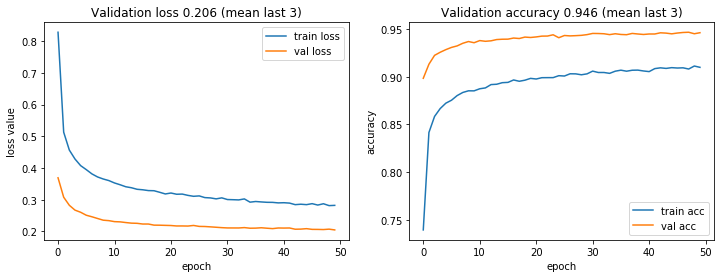

In [18]:
# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy values
ax1.plot(history2.history['loss'], label='train loss')
ax1.plot(history2.history['val_loss'], label='val loss')
ax1.set_title('Validation loss {:.3f} (mean last 3)'.format(
    np.mean(history2.history['val_loss'][-3:]) # last three values
))
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss value')
ax1.legend()

# Plot accuracy values
ax2.plot(history2.history['acc'], label='train acc')
ax2.plot(history2.history['val_acc'], label='val acc')
ax2.set_title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(history2.history['val_acc'][-3:]) # last three values
))
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()
plt.show()

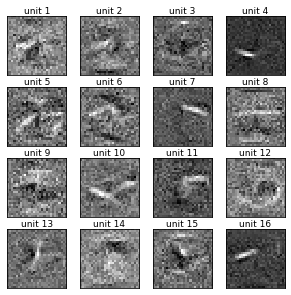

In [19]:
# Retrieve first hidden layer
hidden2 = model2.layers[0]

# Get weights/biases
weights_hidden2, biases_hidden2 = hidden2.get_weights()

# Create figure with 16 subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(5, 5))

# Plot the weights of the 16 hidden units
for i, axis in enumerate(axes.flatten()):
    # Get weights of i-th hidden unit
    weights2 = weights_hidden2[:, i]

    # Reshape into 28 by 28 array
    weights2 = weights2.reshape(28, 28)

    # Plot weights
    axis.set_title('unit {}'.format(i+1), size=9, pad=2)
    axis.imshow(weights2, cmap=plt.cm.gray_r) # Grayscale
    axis.get_xaxis().set_visible(False) # Disable x-axis
    axis.get_yaxis().set_visible(False) # Disable y-axis

plt.show()

### Regularization L2

In [20]:

# Create model
model3 = Sequential()

# Hidden layer
model3.add(Dense(
    units=16, activation=activations.relu, input_dim=28*28,
    kernel_initializer=initializers.VarianceScaling(scale=2.0, seed=0)))

# Output layer
model3.add(Dense(
    units=10, activation=activations.softmax,
    kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=0),
    kernel_regularizer=tf.keras.regularizers.l2(l=0.05))
)


model3.compile(
    optimizer='sgd', # .. or optimizers.SGD(lr=0.01)
    loss='sparse_categorical_crossentropy', # .. or losses.sparse_categorical_crossentropy
    metrics=['acc'] # .. or metrics.sparse_categorical_accuracy
)

In [21]:
# Fit model
history3 = model3.fit(
    x=X_train_preprocessed, y=y_train,
    validation_split=0.2, batch_size=32, epochs=50,
    shuffle=True # Shuffle training samples
)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 1s 23us/step - loss: 1.0097 - acc: 0.8130 - val_loss: 0.6036 - val_acc: 0.8934
Epoch 2/50
48000/48000 [==============================] - 1s 20us/step - loss: 0.5582 - acc: 0.8948 - val_loss: 0.4875 - val_acc: 0.9067
Epoch 3/50
48000/48000 [==============================] - 1s 20us/step - loss: 0.4818 - acc: 0.9046 - val_loss: 0.4399 - val_acc: 0.9132
Epoch 4/50
48000/48000 [==============================] - 1s 20us/step - loss: 0.4429 - acc: 0.9106 - val_loss: 0.4121 - val_acc: 0.9179
Epoch 5/50
48000/48000 [==============================] - 1s 20us/step - loss: 0.4177 - acc: 0.9140 - val_loss: 0.3927 - val_acc: 0.9205
Epoch 6/50
48000/48000 [==============================] - 1s 20us/step - loss: 0.3992 - acc: 0.9166 - val_loss: 0.3781 - val_acc: 0.9229
Epoch 7/50
48000/48000 [==============================] - 1s 20us/step - loss: 0.3848 - acc: 0.9189 - val_loss: 0.3662 - val_acc

In [22]:
(test_loss3, test_accuracy3) = model3.evaluate(X_test_preprocessed, y_test, batch_size=32)

print('Test loss: {:.2f}'.format(test_loss3))
print('Test accuracy: {:.2f}%'.format(100*test_accuracy3)) 

10000/10000 [==============================] - 0s 11us/step
Test loss: 0.27
Test accuracy: 93.95%


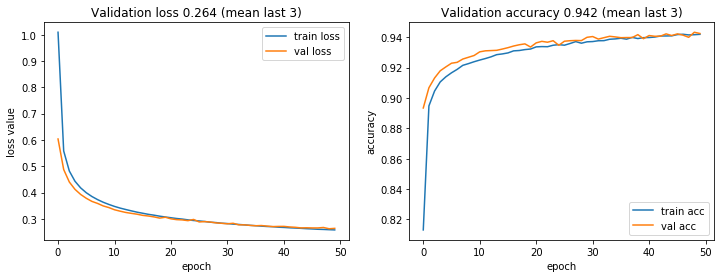

In [23]:
# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy values
ax1.plot(history3.history['loss'], label='train loss')
ax1.plot(history3.history['val_loss'], label='val loss')
ax1.set_title('Validation loss {:.3f} (mean last 3)'.format(
    np.mean(history3.history['val_loss'][-3:]) # last three values
))
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss value')
ax1.legend()

# Plot accuracy values
ax2.plot(history3.history['acc'], label='train acc')
ax2.plot(history3.history['val_acc'], label='val acc')
ax2.set_title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(history3.history['val_acc'][-3:]) # last three values
))
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()
plt.show()

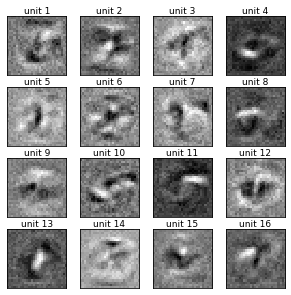

In [24]:
# Retrieve first hidden layer
hidden3 = model3.layers[0]

# Get weights/biases
weights_hidden3, biases_hidden3 = hidden3.get_weights()

# Create figure with 16 subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(5, 5))

# Plot the weights of the 16 hidden units
for i, axis in enumerate(axes.flatten()):
    # Get weights of i-th hidden unit
    weights3 = weights_hidden3[:, i]

    # Reshape into 28 by 28 array
    weights3 = weights3.reshape(28, 28)

    # Plot weights
    axis.set_title('unit {}'.format(i+1), size=9, pad=2)
    axis.imshow(weights3, cmap=plt.cm.gray_r) # Grayscale
    axis.get_xaxis().set_visible(False) # Disable x-axis
    axis.get_yaxis().set_visible(False) # Disable y-axis

plt.show()

# Advanced Keras

So far, we always worked with in-memory data sets. In this unit, we will see how to scale up and create **data generators that read images from the disk with Keras image generators** and go through a concrete example with a .png version of the CIFAR-10 data set.

### Keras Image Generators

The first step is to create an **ImageDataGenerator** which specifies how to process each image. In our case, we will simply apply 0-1 rescaling to all images and **additional data augmentation to the train set to increase the size of the dataset** and add some variation

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create image generator
train_generator = ImageDataGenerator(
    rescale=1/255, horizontal_flip=True, rotation_range=5, validation_split=0.2)
test_generator = ImageDataGenerator(rescale=1/255)

We use the rescale parameter to normalize the images between zero and one, and the horizontal_flip and rotation_range transformations to get slightly different variants of the images each time we sample from the images to fight overfitting and virtually augment the data set to improve training. This is why we only use those parameters for the train_generator and not the test_generator one. Optionally, we can also keep a fraction of the data for validation. In this case, we keep 20% of the data as a validation set. Note that they will also go through the training transformations.

The second step is to create an iterator that iterates over the directory of CIFAR-10 .png images. The cifar10 folder can be downloaded from the resources of this unit. To iterate over the directory we can use the flow_from_directory() function from our image generators which takes the path to the directory, the batch size and the target size. This can be useful if we need to resize the images before inserting them into our network. However, in our case, we will keep the 32x32 .png images and set target_size=(32, 32)

In [26]:
import os

# Train, validation and test sets
trainset = train_generator.flow_from_directory(
    os.path.join('cifar10', 'train'), batch_size=32, target_size=(32, 32),
    shuffle=True, subset='training')
validset = train_generator.flow_from_directory(
    os.path.join('cifar10', 'train'), batch_size=32, target_size=(32, 32),
    shuffle=False, subset='validation')
testset = test_generator.flow_from_directory(
    os.path.join('cifar10', 'test'), batch_size=32, target_size=(32, 32),
    shuffle=False)

Found 4000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


We create a trainset and a validset iterator for the images from the train directory and a testset one for the images from the test directory. **Note that we don't need to shuffle the validation and test data (i.e we set shuffle=False)** since shuffling only affects training. Also, we only need to specify the subset argument for the train and validation sets since we used above the optional validation_split parameter from the train_generator.

We can always verify which images are assigned to each data set by looking at the filenames attribute

In [27]:
trainset.filenames[:5]

['airplane\\airplane-101.png',
 'airplane\\airplane-102.png',
 'airplane\\airplane-103.png',
 'airplane\\airplane-104.png',
 'airplane\\airplane-105.png']

In [28]:
validset.filenames[:4]

['airplane\\airplane-001.png',
 'airplane\\airplane-002.png',
 'airplane\\airplane-003.png',
 'airplane\\airplane-004.png']

As we can see, for each class the first 100 images (1000 validation images/10 class) were assigned to the validation set and the rest to the training one. We can verify that those two sets don't intersect with

In [29]:
set(trainset.filenames).intersection(set(validset.filenames))

set()

which returns an empty set for the intersection.

The directory iterators can be used like normal Python iterators ex. in a for loop. By calling next(), we get the next batch of images with their labels

In [30]:
batch_imgs, batch_labels = trainset.next()

print('Batch images:', batch_imgs.shape) # (32, 32, 32, 3)
print('Batch labels:', batch_labels.shape) # (32, 10)

Batch images: (32, 32, 32, 3)
Batch labels: (32, 10)


It's important to note that the iterator returns one-hot encoded labels by default. In our case, we have 10 classes, so batch_label is a 32x10 array

In [31]:
batch_labels[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

We can always retrieve the original class names with the class_indices attribute

In [32]:
trainset.class_indices

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

Note that it is possible to obtain integer encoded labels with the iterator. To do that, one can change the default parameter class_mode = 'categorical' in flow_from_directory() function to class_mode = 'sparse'.

### Training with generators
Let's now see how to train our network with iterators. But first, we need to create the network. This time, we will implement a ConvNet similar to the one we saw in the last subject. To achieve this, we will add Conv2D, MaxPool2D, Flatten and Dense layers to our Sequential model

In [33]:
trainset.num_classes

10

In [34]:
import tensorflow.keras as keras

# Convolutional Network
model = keras.Sequential()


model.add(keras.layers.Conv2D(filters=128, kernel_size=5, strides=2,
                              activation='relu', input_shape=(32, 32, 3)))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.Conv2D(filters=64, kernel_size=3, strides=1,
                              activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))


model.add(keras.layers.Flatten())
#model.add(Dropout(rate=0.2))

model.add(keras.layers.Dense(units=trainset.num_classes, activation='softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 128)       9728      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 64)          73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                2570      
Total params: 86,090
Trainable params: 86,090
Non-trainable params: 0
_________________________________________________________________


Let's compile the model with the Adam optimizer and the categorical_crossentropy loss function which is equivalent to the sparse_categorical_crossentropy one from the last unit, but works with one-hot encoded labels

In [35]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc'])

Let's also create an optional EarlyStopping callback that we can use during the model fitting process. Callbacks are functions that can be applied at different stages of the training procedures. In our case, EarlyStopping will monitor the loss value on the validation set and stop the training once this loss value didn't improve anymore for more than 6 epochs. Early stopping is a common way to fight overfitting.

In [36]:
# End training when accuracy stops improving (optional)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

Now that everything is ready we can implement the model fitting. This time, we need to use the fit_generator() to train the network using data generators. Instead of passing the x/y inputs as we did previously with model.fit(), this function takes a generator which returns the training inputs/labels batches and a validation_data one which returns the validation batches

In [37]:
# Train model
history = model.fit_generator(
    generator=trainset, validation_data=validset, epochs=100, callbacks=[early_stopping])

Epoch 1/100
125/125 [==============================] - 4s 33ms/step - loss: 2.1805 - acc: 0.1820 - val_loss: 2.0010 - val_acc: 0.2620
Epoch 2/100
125/125 [==============================] - 3s 25ms/step - loss: 1.9227 - acc: 0.3008 - val_loss: 1.8149 - val_acc: 0.3430
Epoch 3/100
125/125 [==============================] - 3s 25ms/step - loss: 1.7952 - acc: 0.3638 - val_loss: 1.6841 - val_acc: 0.4120
Epoch 4/100
125/125 [==============================] - 3s 25ms/step - loss: 1.6908 - acc: 0.3925 - val_loss: 1.6264 - val_acc: 0.4040
Epoch 5/100
125/125 [==============================] - 3s 25ms/step - loss: 1.6175 - acc: 0.4128 - val_loss: 1.6485 - val_acc: 0.4020
Epoch 6/100
125/125 [==============================] - 3s 25ms/step - loss: 1.5826 - acc: 0.4365 - val_loss: 1.5529 - val_acc: 0.4230
Epoch 7/100
125/125 [==============================] - 3s 25ms/step - loss: 1.5326 - acc: 0.4447 - val_loss: 1.5871 - val_acc: 0.4300
Epoch 8/100
125/125 [==============================] - 3s 26ms

Using the early_stopping callback means that the epoch=100 parameter is consider as an upper limit value and the training will be stopped already earlier if the val_loss value doesn't improve anymore.

Let's visualize the training curves with the code from the previous unit

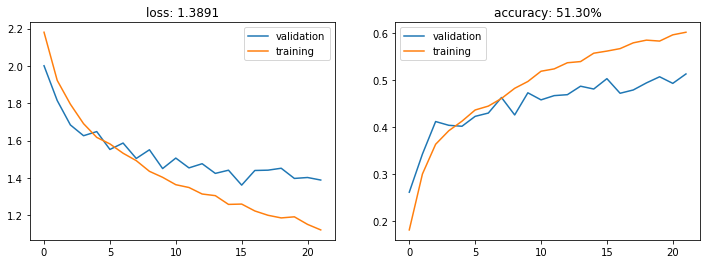

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot loss values
ax1.set_title('loss: {:.4f}'.format(history.history['val_loss'][-1]))
ax1.plot(history.history['val_loss'], label='validation')
ax1.plot(history.history['loss'], label='training')
ax1.legend()

# plot accuracy values
ax2.set_title('accuracy: {:.2f}%'.format(history.history['val_acc'][-1]*100))
ax2.plot(history.history['val_acc'], label='validation')
ax2.plot(history.history['acc'], label='training')
ax2.legend()

plt.show()

The code creates two plots: one with the loss and the other with the accuracy, each graph with the training and validation curves. The results can slightly change here because of training data shuffling and graph random initialization.

Our very small network reaches an accuracy of around 52% after 25 epochs which is not bad compared to the most-frequent baseline at 10%.

> Challenge Can you improve the results with a more sophisticated network?

Note that, unlike Scikit-learn library, Keras API can handle both integer encoded labels and one-hot encoded labels in order to perform multiclass classification. However, one needs to use the appropriate loss function: sparse_categorical_crossentropy for integer encoded labels and categorical_crossentropy for one-hot encoded labels.

### Prediction and final test estimations

Keras models also expose a predict_generator() and a evaluate_generator() function to make predictions and evaluate them from generators. For instance, we can compute the network output for the 1,000 test images by running

In [39]:
test_preds = model.predict_generator(testset)
print('Predictions:', test_preds.shape)

Predictions: (1000, 10)


The test_preds variable contains one row for each data point and one column for each class. We can then get the class digits (0, 1, 2, .., 9) associated with the highest predicted score for each image by taking the argmax across the horizontal axis test_preds.argmax(axis=1). For instance, we can use that to compute the confusion matrix

# Saving models

In practice, training typically takes several hours, days or even weeks. In this unit, we will see how to save our models and their trained parameters with Keras. This allows us to use them again at a later timepoint and gives us the possibility to easily share them with others.

# Keras pretrained model

In [40]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
import os
os.environ["CUDA_VISIBLE_DEVICES"]= "-1"

In this code, we also import Keras backend module that is usually named K. So far, we let Keras do the house keeping with our models: add the nodes, variables and operations to the default graph, handle the session. However, we will now work with large models that have several millions of parameters. For this reason, we will avoid cluttering by manually clearing the graph with K.clear_session()

In [41]:
K.clear_session() # Create a new graph (avoid clutter)

Once the session is cleared, we can go ahead and import the Xception ConvNet from the Keras applications module.

In [42]:
model = keras.applications.Xception(weights='imagenet')

Note that we not only load the network architecture but also its pretrained parameters that are the result of a prior training process on the ImageNet data set. To get a complete list of available models, see the Keras applications reference.https://keras.io/applications/

Let's take a look at the graph

In [43]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

You should see that the graph has a very large number of layers compared to what we've seen in this course. It's out of the scope of this course to understand its architecture, however, you should recognize some familiar layers such as Conv2D, MaxPooling2D and a Dense at the end of the network for the final classification. Overall, the network has 23 million parameters.

### Sample image predictions
The network was trained to recognize a thousand predefined categories. Let's pass a sample image through the network to see if it can recognize it. First, we need to load the image (available in the resources) with PIL

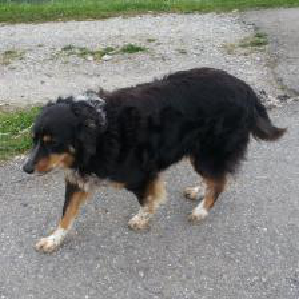

In [44]:
import PIL.Image as Image

img = Image.open('photo.jpg').resize(size=[299, 299])
img

The Xception network works with 299x299 images, so we call resize() to ensure that it has the correct size - you can always refer to the Keras.applications documentation to get details about the expected image formats

**We can then convert the image into a Numpy array. Neural networks work with batches of images. For this reason, we need to add a new dimension for the number of images which in our case is one**

In [45]:
import numpy as np

img_batch = np.array(img)[np.newaxis, :, :, :]

print('Original size:', np.array(img).shape) 
print('Batch size:', img_batch.shape) # (1, 299, 299, 3)
print('Data type:', img_batch.dtype) # uint8

Original size: (299, 299, 3)
Batch size: (1, 299, 299, 3)
Data type: uint8


In [46]:
predictions = model.predict(img_batch/255)
predictions.shape

(1, 1000)

The network also requires the standard 0-1 image normalization, so we need to divide the pixels values by 255 before calling the function. We get one probability per class - this corresponds to a softmax output.

Let's take a look at the predictions for the first 5 classes

In [47]:
print(predictions[0, :5])

[0.00025699 0.00036301 0.00066391 0.00054555 0.00024192]


We can retrieve the overall top N predictions with decode_predictions(.. , N)

In [48]:
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions

decode_predictions(predictions, top=5)

[[('n02107683', 'Bernese_mountain_dog', 0.2670138),
  ('n02107908', 'Appenzeller', 0.04608712),
  ('n02108551', 'Tibetan_mastiff', 0.043670688),
  ('n02106030', 'collie', 0.031259242),
  ('n02101006', 'Gordon_setter', 0.02994522)]]

### Save and load models with the help of h5 files

Keras models have a save() method which allows us to save the network architecture and weights in a single .h5 binary file.


In [49]:
model.compile(optimizer='sgd', loss='categorical_crossentropy') # pour éviter message d'erreur "not compiled"
model.save('model.h5')

If you check the size of the file, you should see that this model is around 100MB.

To load a saved model, we can use load_model(). Let's clear the graph again, load the model from the file and verify that we can get the same predictions as before

In [50]:
K.clear_session() # Create new graph to avoid clutter
new_model = keras.models.load_model('model.h5') # Load model

# New predictions
decode_predictions(new_model.predict(img_batch/255))


[[('n02107683', 'Bernese_mountain_dog', 0.2670138),
  ('n02107908', 'Appenzeller', 0.04608712),
  ('n02108551', 'Tibetan_mastiff', 0.043670688),
  ('n02106030', 'collie', 0.031259242),
  ('n02101006', 'Gordon_setter', 0.02994522)]]

# Transfer learning

In this course, we saw several machine learning methods that work on sets of features i.e. there is **no structure** in the input (e.g. the house pricing or open foot datasets). However, we often want to build models that work on inputs that have a **complex structure such as texts, images, sounds or videos. We typically process such inputs with deep neural networks**. Having to learn a huge number of parameters also means that we need to process a large amount of data. Additionally, it can be very difficult to find the appropriate network architecture for a given kind of data structure (i.e. pictures of faces, sound bites of voices, etc.).

### TensorFlow Hub
In this unit, we will see how to **download state of the art pretrained neural networks from TensorFlow Hub** and use them to extract high-level features from complex, structured inputs that we can then use with the machine learning models from the course such as logistic regression, random forests etc.

You can directly import the TensorFlow Hub module from the exts-ml course environment

In [51]:
import tensorflow as tf
import tensorflow_hub as hub

All models are available via the hub module. For reference, here are a few important links
- TensorFlow Hub guide https://www.tensorflow.org/hub/
- List of modules https://tfhub.dev/

The modules are classified by type of input and task. In this unit, we will use MobileNet v2 to extract a **feature vector from an image** and the ELMO module to extract **embeddings from texts** i.e. texts high-level representations that we can use in our machine learning tasks.

### Image feature extraction

Batch size: (1, 224, 224, 3)


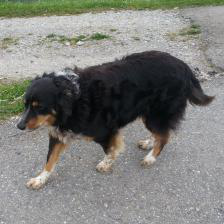

In [52]:
import PIL.Image as Image
import numpy as np

# Load image
img = Image.open('photo.jpg')

# Create batch for network
img_resized = img.resize([224, 224], resample=Image.BILINEAR) # Expected size
img_batch = np.array(img_resized, dtype=np.float32)[np.newaxis, :, :, :]/255
print('Batch size:', img_batch.shape) # (1, 224, 224, 3)

img

By default, TensorFlow Hub image modules work with float32 images normalized between zero and one. The expected input size is written on the MobileNet V2 module page. In this case, it's 224x224.

Let's now create a graph that will contain the module and add the necessary nodes and placeholders that we will use to feed data to the model.

In [53]:
# Create graph
img_graph = tf.Graph()

with img_graph.as_default():
    # Download module
    module_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2'
    feature_extractor = hub.Module(module_url)

    # Create input placeholder
    input_imgs = tf.placeholder(dtype=tf.float32, shape=[None, 224, 224, 3])

    # A node with the features
    imgs_features = feature_extractor(input_imgs)

    # Collect initializers
    init_op = tf.group([
        tf.global_variables_initializer(), tf.tables_initializer()
    ])

img_graph.finalize() # Good practice: make the graph "read-only"

RuntimeError: Missing implementation that supports: loader(*('C:\\Users\\lyeso\\AppData\\Local\\Temp\\tfhub_modules\\adfe0cf8d843e3588bfb9602e32a718b12212904',), **{})

In this code, we create a computational graph called img_graph that will contain our MobileNet V2 module. To add the pretrained network to this graph we just need to download it with hub.module(url). **To use the module, we simply pass the placeholder to the node feature_extractor(input_imgs) and get a node that represents the extracted high-level features.**

Finally, we collect the initializers and store them in init_op. TensorFlow Hub modules require us to run the usual global_variables_initializer and an additional tables_initializer. We usually group them with tf.group([.., ..]) in a single init_op operation. And as a final step, we used the graph's finalize() function to make it read-only and prevent that any new operations are added to the graph.

Let's create a session with this graph, run initialization and pass our sample image through the graph to get the imgs_features out

In [ ]:
# Create a session
sess = tf.Session(graph=img_graph)

# Initialize it
sess.run(init_op)

# Extract features
features = sess.run(imgs_features, feed_dict={input_imgs: img_batch})
features.shape

The feature vector size is written in the MobileNet V2 module page. In this case, it's a vector with 1,280 values that we can now use as a high-level representation in our machine learning tasks ex. image classification, clustering, etc.

Let's take a look at the distribution of the feature

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(features[0], bins=30)
plt.title('Image high-level feature distribution')
plt.show()

We can see that our network returned positive values and that most of the features are very small.

# Another example with texts

We just saw above how to extract a set of high-level features from an image. This is really convenient as images are complex inputs: they have a "structure" i.e. pixels are arranged on a 2d grid. This structure is important to understand the content of the image: would you be able to recognize the dog on the image from above if the image pixels were randomly shuffled? **For this reason, the "classical models" that we have seen at the beginning of this course would be a bad fit for this kind of input, because they do not take into account any structure: shuffling the columns of the X matrix before a random forest, k-NN or logistic regression doesn't change the results!**

**Images are not the only input with a structure, audio and texts are two common examples where the input displays some structure ex. the order of the words in a sentence is important.** In other words, when working with such input, we need to find a way to extract a set of "high-level features" that we can then pass to the classical ML models. This can be done by hand by manually defining what those features should be. For instance, in a text classifier that identifies paragraphs related to energy and politics, we could create a set of indicator variables for popular words related to those two topics ex. power, atom, solar, polls, election, senate. The other approach seen above with images is to "re-use" a neural network that was specifically trained on a large amount of data using lot of computational resources to extract meaningful high-level features.

TensorFlow Hub (https://tfhub.dev/) provides many different models to achieve this for four "structured" data types: image, text, video and audio. The code is generally similar to the one shown above, with only the module_url changing and potentially some preprocessing depending on the model. In the case of texts, extracting high-level features is often referred to as "computing embeddings" - you can check this page to have a full list of TensorFlow v1 models to compute text embeddings: TensorFlow v1 text embeddings models (https://tfhub.dev/s?module-type=text-embedding&tf-version=tf1)

For each one, the documentation gives a code example that you can follow. Note that things can sometimes be a bit more complex if the model requires more preprocessing. To keep things simple, we will now use the ELMO module as example, because it doesn't require any preprocessing.

The code is similar to the one from above

In [ ]:
# Create graph
text_graph = tf.Graph()

with text_graph.as_default():
    # Download module
    module_url = 'https://tfhub.dev/google/elmo/3' # <---- URL changed to ELMO
    embedding_model = hub.Module(module_url)

    # Create input placeholder
    input_text = tf.placeholder(dtype=tf.string, shape=[None]) # <----- Data type changed to tf.string

    # A node with the embedding
    embedded_text = embedding_model(input_text)

    # Collect initializers
    init_op = tf.group([
        tf.global_variables_initializer(), tf.tables_initializer()
    ])

text_graph.finalize() # Good practice: make the graph "read-only"

We can now use our module with a new session. The network should produce similar vectors for topics that are closely related

In [ ]:
# Create a session
sess = tf.Session(graph=text_graph)

# Initialize it
sess.run(init_op)

# Get embeddings
topics = [
    'Data science involves math, programming and substantive expertise',
    'There are many mountains and cows in Switzerland',
    'The idea behind Machine learning is to learn a model that generalizes from data using code',
    'In winter, swiss people often ski and eat cheese'
]

embedded_topics = sess.run(embedded_text, feed_dict={input_text: topics})
embedded_topics.shape # (4, 1024)

We get a 1024 feature vector (embedding) for each text in our list: (4, 1024) is hence the shape of our X matrix

Let's now compare the vectors pairwise. A simple way to achieve this is to compute the inner product between each pair of vectors. Similar vectors produce larger scores

In [ ]:
import numpy as np

np.inner(embedded_topics, embedded_topics)

In this matrix, the (i, j) element represent how far the i-th sentence is to the j-th one. This score is given by the vector product. From the matrix, we can see that the 1st sentence is closer to the 3rd one than the two other ones, so are the 2nd and 4th sentences.

### Practical note on TensorFlow Hub modules

Note that the choice of model also depends on the application and it's important to read the TensorFlow Hub page before using the model on your data set and do some research online about use cases for that model. For instance the Universal Sentence Encoder Cross-lingual (XLING) (https://tfhub.dev/google/universal-sentence-encoder-xling-many/1) is a better fit for longer text documents and can handle several languages including English, Spanish, German and French. However, the preprocessing isn't necessarily as straightforward as the ELMO module from above, in particular if we don't use the latest TensorFlow version. One solution to this, is to

- Create another Conda environment with the latest TensorFlow version
- Extract the embeddings in a notebook running in this "updated" environment
- Save those embeddings in a features.npy file
- Do the rest of the analysis with the exts-ml course environment, loading this features.npy matrix

TensorFlow Hub also provides notebooks that demonstrate how to use their latest modules. Those notebooks can be downloaded offline and used in Jupyter Lab, but can also be run online via the Google Colab service https://research.google.com/colaboratory/. This can be particularly convenient as computations are run in the cloud with powerful machines and no local installation is needed. This can be an option to extract the features.npy and then continue the analysis locally on your machine. For instance, check the "Open Colab Notebook" link in MobileNet v5 module : https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5

Also, note that TensorFlow has frequent updates and the code to extract high-level features will be different from the one from above, but the features extracted from the network remains the same. Hence the importance of saving embeddings in a features.npy file as a "stable starting point".




# Additional ML and DL resources

Python benefits from a wide ecosystem of ml/dl libraries and projects. We cannot cover everything in the course. However, you can find on this page some additional resources given for reference

### TensorFlow ecosystem
- TensorFlow's visualization toolkit - TensorBoard https://www.tensorflow.org/tensorboard
- Code-free probing of ml models - What-If tool https://pair-code.github.io/what-if-tool/
- Collection of datasets ready to use in TF - TensorFlow datasetshttps://www.tensorflow.org/datasets/
- Libraries & extensions https://www.tensorflow.org/resources/libraries-extensions
### TensorFlow different platforms
- Mobile and IoT devices - TensorFlow Lite https://www.tensorflow.org/lite/
- Deploy/train dl models in the browser/node.js - TensorFlow.js https://www.tensorflow.org/js/
- Deploy production ML pipelines - TensorFlow Extended https://www.tensorflow.org/tfx/
### Other resources
- Jupyter notebook in the cloud with TF support - Google Colaboratory https://colab.research.google.com/notebooks/welcome.ipynb
- Feed of ML/DL projects, papers, repositories, datasets… - PapersWithCode https://paperswithcode.com/